# Collaboration and Competition

---

## 0. Learning Algorithm
---
To solve the Unity tennis problem, I choose [MADDPG algorithm](http://arxiv.org/abs/1706.02275)(Lowe et al., Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments)

**Algorithm**

MADDPG(Multi-Agent Deep Deterministic Policy Gradient) Algorithm extrapolates the DDPG algorithm to the multi-agent case. This general purpose algorithm is applicable to cooperative-competitive environment like this tennis problem. 

This algorithm takes the centralized training with decentralized execution. So each agent uses other agent's policies at training time, but this information is not used in test time. To put it concretely, critic network takes not only its own observation and action but also other agent's observations and actions. But when the agents try to choose actions at test time, they will use their own observation only.

Full MADDPG training algorithm is presented as follows. Note that local actor network(not target actor network)is used to produce particular one agent's action $a_i$ when updating actor network. But the other agents' actions are just the actions sampled from replay buffer.

<br>
<figure>
  <img src = "./pic/maddpg.png" width = 80% style = "border: thin silver solid; padding: 10px">
      <figcaption style = "text-align: center; font-style: italic">Fig 1. - MADDPG Algorithm. (Lowe et al., Multi-Agent Actor-Critic for Mixed Cooperative-Competitive Environments, 13.)</figcaption>
</figure> 
<br>

Just like DDPG algorithm, I use replay buffer and Ornstein-Uhlenbeck noise process. The replay buffer is shared through all agents but it stores other agent's information for the centralized action-value function. 

**Model Architecture**

Based on the experiment details from [Lowe et al.](http://arxiv.org/abs/1706.02275) , I used the similar shallow and small networks. Both actor and critic networks have 3 fully connected layers. These layers are consist of an input layer and 2 hidden layers.  Since the state size is 24, So the input size of the actor network is 24. And the input size of critic network is 52, because It takes all the other agent' observations and actions. In this project, there are 2 agents, so 2*(state_size+action_size) = 54.

```
Actor(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=96, bias=True)
  (bn2): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=96, out_features=96, bias=True)
  (bn3): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=96, out_features=2, bias=True)
)


Critic(
  (fc1): Linear(in_features=52, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=1, bias=True)
)
```

## 1. Load Packages and Environment

---

In [1]:
%load_ext autoreload
%autoreload 1

In [2]:
import torch
import torch.nn.functional as F
import torch.nn.init as I
import torch.nn as nn
import numpy as np
from collections import deque

import os
import json
import glob
import matplotlib.pyplot as plt
%matplotlib inline

%aimport ddpg, maddpg

from maddpg import MADDPG

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

In [3]:
from unityagents import UnityEnvironment
import numpy as np

env = UnityEnvironment(file_name="data/Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


## 2. Training
---
### 1. Hyperparameters

You need to set all the hyperparameters to run the training code or to see the actual agents's behaviours.

In [4]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

In [5]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24


In [6]:
model_name = 'model_18'
model_save_path = 'model/'
params = {}
# Model Hyperparameters
params['BUFFER_SIZE'] = int(1e6)
params['BATCH_SIZE'] = 256
params['GAMMA'] = 0.95
params['TAU'] = 1e-2
params['LR_ACTOR'] = 1e-3
params['LR_CRITIC'] = 1e-3
params['WEIGHT_DECAY'] = 0.0001
params['TRAIN_ITER'] = 15
params['TRAIN_FREQ'] = 10
params['FC1'] = 96
params['FC2'] = 96
params['SEED'] = 0
params['CLIPPING'] = False
# Noise parameters
params['SIGMA'] = 0.15
params['THETA'] = 0.15
params['SCALE'] = 0.9


# model save frequency
CHECKPOINT_FREQ = 3
# score printing frequency
PRINT_EVERY = 50
GOAL_AVG_SCORE = 0.5

### 2. Set up

Check if there is previous saved model. If there are checkpoints, then load the checkpoints and scores information. 

In [7]:
def set_up(model_name, params):
    """
    set up for traning
    If the model and its score already exist, load the model and score
    
    Returns
    ======
    scores (list) : score history 
    score_deque (deque) : score window 
    current_episode (int) : current episode number 
    multiAgent (MultiAgent)
    """
    target_path = model_save_path+model_name
    # If the model already exists
    if os.path.exists(target_path):
        # Check it there are checkpoint files
        if not glob.glob(target_path+'/*.pth'):
            raise Exception('Previous model file doesnt exists')
        # Get params from the previous saved params.json
        with open(target_path+'/params.json', 'r') as f:
            # previous param dict
            prev_params = json.load(f)
        # Get previous score data    
        with open(target_path+'/scores.json', 'r') as f:
            prev_score_data = json.load(f)
            score_deque = deque(maxlen=100)
            scores = []
            current_episode = 1
            if len(prev_score_data) !=0 :
                current_episode = prev_score_data['current_episode']
                scores = prev_score_data['scores']
                for score in scores:
                    score_deque.append(score)
        
        multiAgent = MADDPG(num_agents, state_size, action_size, params)
        multiAgent.load_model(path=target_path)
        
    # If this is first time ; no previous saved model
    else:
        print('This is first time to run the model : {}'.format(model_name))
        os.makedirs(target_path)
        # Write parameters into json file
        with open(target_path+'/params.json', 'w') as f:
            json.dump(params, f)
        with open(target_path+'/scores.json', 'w') as f:
            json.dump({}, f)
            
        current_episode = 1
        scores = []
        score_deque = deque(maxlen=100)
        multiAgent = MADDPG(num_agents, state_size, action_size, params)
    
    return multiAgent, scores, score_deque, current_episode, target_path

In [8]:
maddpg, scores, score_deque, current_episode, target_path = set_up(model_name, params)

This is first time to run the model : model_18


###  3.Training Code

In [9]:
def training(num_episodes=2200, max_timestep=1000):
    
    for i in range(current_episode,num_episodes+1):
        env_info = env.reset(train_mode=True)[brain_name]
        # [num_agets, state_size]
        states = env_info.vector_observations
        agents_scores = np.zeros(num_agents)
        
        for t in range(max_timestep):
            # [num_agents, action_size]
            actions = maddpg.act(states)
            
            env_info = env.step(actions)[brain_name]
            next_states = env_info.vector_observations
            rewards = env_info.rewards
            dones = env_info.local_done
            rewards = env_info.rewards
            
            maddpg.step(states, actions, rewards, next_states, dones)
            agents_scores += rewards
            states = next_states
            if np.any(dones):
                break
        # Episode score
        episode_score = max(agents_scores)
        score_deque.append(episode_score)
        scores.append(episode_score)
        
        if i % CHECKPOINT_FREQ == 0 or i==num_episodes:
            maddpg.save_model(target_path)
            with open(target_path+'/scores.json', 'w') as f:
                score_data = {'current_episode':i, 'scores': scores}
                json.dump(score_data, f)
                
                
        if (i% PRINT_EVERY) == 0:
            print('Episode : {} \t Current Score: {:.4f} \t Average Score : {:.4f}'. format(i, episode_score, np.mean(score_deque)))
            
        if np.mean(score_deque) >= GOAL_AVG_SCORE:
            print('The number of episodes needed to solve the problem : {}'.format(i))
            print('Episode : {} \t Current Score: {:.4f} \t Average Score : {:.4f}'. format(i, episode_score, np.mean(score_deque)))
            maddpg.save_model(target_path)
            break
            
    return scores, maddpg.avg_actor_history, maddpg.avg_critic_history

In [10]:
total_score, actor_loss, critic_loss = training()

Episode : 50 	 Current Score: 0.0000 	 Average Score : 0.0040
Episode : 100 	 Current Score: 0.0000 	 Average Score : 0.0020
Episode : 150 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 200 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 250 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 300 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 350 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 400 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 450 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 500 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 550 	 Current Score: 0.0000 	 Average Score : 0.0000
Episode : 600 	 Current Score: 0.0000 	 Average Score : 0.0009
Episode : 650 	 Current Score: 0.0000 	 Average Score : 0.0054
Episode : 700 	 Current Score: 0.0000 	 Average Score : 0.0109
Episode : 750 	 Current Score: 0.0000 	 Average Score : 0.0109
Episode : 800 	 Current Score: 0.0000 	 Average Score : 

### 4. Plot of Results

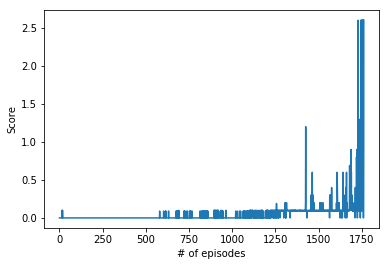

In [11]:
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(np.arange(len(total_score)), total_score)
plt.xlabel('# of episodes')
plt.ylabel('Score')
plt.show()

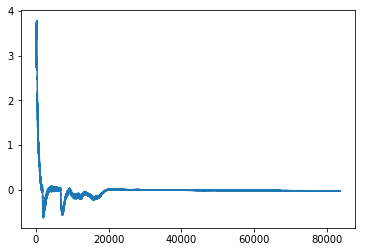

In [12]:
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(np.arange(len(actor_loss)), actor_loss)
plt.show()

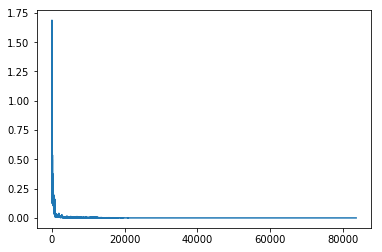

In [13]:
fig = plt.figure()
ax=fig.add_subplot(111)
plt.plot(np.arange(len(critic_loss)), critic_loss)
plt.show()

## 3. Watch the agent

In [14]:
# load the weights from file
multiAgent = MADDPG(num_agents, state_size, action_size, params)
multiAgent.load_model(path=target_path)

In [18]:
multiAgent.agents_list[0].local_actor

Actor(
  (bn1): BatchNorm1d(24, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc1): Linear(in_features=24, out_features=96, bias=True)
  (bn2): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc2): Linear(in_features=96, out_features=96, bias=True)
  (bn3): BatchNorm1d(96, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc3): Linear(in_features=96, out_features=2, bias=True)
)

In [17]:
multiAgent.agents_list[0].local_critic

Critic(
  (fc1): Linear(in_features=52, out_features=96, bias=True)
  (fc2): Linear(in_features=96, out_features=96, bias=True)
  (fc3): Linear(in_features=96, out_features=1, bias=True)
)

In [20]:
scores = np.zeros(num_agents)
env_info = env.reset(train_mode=False)[brain_name]
state = env_info.vector_observations
while True:
    actions = multiAgent.act(states)
            
    env_info = env.step(actions)[brain_name]
    next_states = env_info.vector_observations
    rewards = env_info.rewards
    dones = env_info.local_done
    rewards = env_info.rewards

    multiAgent.step(states, actions, rewards, next_states, dones)
    scores += rewards
    states = next_states
    if np.any(dones):
        break 
            
episode_score = max(scores)
print('Current Episode Score: {:.4f}'. format(episode_score))
env.close()

Current Episode Score: 1.1000


## 4. Future Works

Even though the problem can be solved by the current settings, It has several things to be imporved. First off, More fine-tuning hyper-paramters might be good start, but it could cost too much times. There are some ideas and I leave these investigations to future work.

1. *Prioritized Experience Replay*

    Current replay buffer samples the experience unfiormly. But certain experience might be more important than ohters. So by giving some probability based on priority to each experince, [Priortized Experience Replay buffer](https://arxiv.org/abs/1511.05952) can sample important expericens more frequently.
    
        
2. *Applying Other Actor-Critic methods*
    
    There are many other actor-critic method such as TRPO(Trust Region Policy Optimization), TNPG(Truncated Natural Policy Gradient) which outperform the DDPG algorithm([Duan et al., Benchmarking Deep Reinforcement Learning for Continuous Control](https://arxiv.org/abs/1604.06778)). The current DDPG algorithm update actor network by using the policy gradient which depends on critic network. So the quality of critic learning procedure might impact the performance of actor network. There have been researches to improve critic learning procedure([Bellemare et al., A Distributional Perspective on Reinforcement Learning](https://arxiv.org/pdf/1707.06887.pdf)). [Barth-Maron et al.](http://arxiv.org/abs/1804.08617) proposed D4PG algorithm with several ideas such as modifying the training procedure and utilizing N-step returns. These works are candidates for the future works.
    
    
3. *Other Normalization Techniques*

    Current model only use batch normalization in actor network. I didn't use batch normalization layer in critic network because pytorch interprete 3D shape tensor input such as state tensor[batch_size, num_agents, state_size] in different way from what i expect. Pytorch has [other normalization layers](https://pytorch.org/docs/stable/nn.html#normalization-layers) like layer norm, instance norm, local reponse norm. These normalization layers might improve the training of networks.